## 1. 라이브러리 로드

In [1]:
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
import numpy as np
from copy import copy

from numpy.random import uniform, normal, choice

from IPython.display import SVG, display  # Scalable Vector Graphics, SVG
def show(page):
    display(SVG(page.svg()))

## 2. 자주 사용할 함수 정의

In [2]:
def glyphcommands(f, ch):
    return Path([copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])])

def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

## 3. 데이터 로드

폰트명: b'NanumSquare_acEB'
Density: 1000


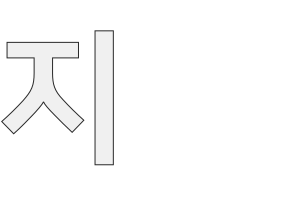

In [3]:
f = font.open("fonts/NanumSquare_0.ttf")
path_list = glyphcommands(f,"지")
cmd_list = path_list.commands

print("폰트명:", f.name)
print("Density:", f.density)

page = document(300, 200, 'pt').addpage()
pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(240, 240, 240))
page.place(pen.path(path_list.scale(144/f.density).translate(0, 144)))

show(page)

In [4]:
def get_dir_of_glyph(cmd, pre_x, pre_y):
    
    direct = ""    
    if type(cmd) == moveto:
        direct += "start"
        return direct

    # 좌우
    if cmd.x > pre_x:
        direct += "right"
    elif cmd.x < pre_x:
        direct += "left"
    else:
        direct += ""
    
    # 상하
    if cmd.y > pre_y:
        direct += "down"
    elif cmd.y < pre_y:
        direct += "up"
    else:
        direct += ""
        
    return direct

In [5]:
def get_dir_list(path):
    dir_list = []
    
    pre_x, pre_y = -9999, -9999
    for idx, cmd in enumerate(path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
        elif type(cmd) in (lineto, quadto, curveto):
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            dir_list.append("fin")

    print(dir_list)
    
    return dir_list

In [6]:
#import numpy as np
def cut_glyph(direct, path):
    # c를 리스트에 어펜드
    # num = 나누는 수
    result = []
    pre_x = -9999
    pre_y = -9999

    for idx, cmd in enumerate(path):
        num=1
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            c = moveto(cmd.x,cmd.y)
            result.append(c)

        elif type(cmd) == lineto:
            if direct[idx] == "right":
                
                if abs(cmd.x - pre_x) > 500:
                    num = 8
                elif 400 <= abs(cmd.x - pre_x) and abs(cmd.x - pre_x) < 500:
                    num = 5    
                elif 200 <= abs(cmd.x - pre_x) and abs(cmd.x - pre_x) < 400:
                    num = 3
                else:
                    num = 2

                for i in  range(1, num + 1):
                    temp_x = pre_x + i * abs(cmd.x - pre_x) / num
                    c = lineto(temp_x, cmd.y)
                    result.append(c)

            elif direct[idx] == "down":

                if abs(cmd.y - pre_y) > 500:
                    num = 10
                elif 400 <= abs(cmd.y - pre_y) and abs(cmd.y - pre_y) < 500:
                    num = 5    
                elif 200 <= abs(cmd.y - pre_y) and abs(cmd.y - pre_y) < 400:
                    num = 3
                else:
                    num = 2


                for i in  range(1, num + 1):
                    temp_y = pre_y + i * abs(cmd.y - pre_y) / num 
                    c = lineto(cmd.x, temp_y)
                    result.append(c)

            elif direct[idx] == "left":

                if abs(cmd.x - pre_x) > 500:
                    num = 8
                elif 400 <= abs(cmd.x - pre_x) and abs(cmd.x - pre_x) < 500:
                    num = 5    
                elif 200 <= abs(cmd.x - pre_x) and abs(cmd.x - pre_x) < 400:
                    num = 3
                else:
                    num = 2

                for i in  range(1, num + 1):
                    temp_x = pre_x - i * abs(cmd.x - pre_x) / num
                    c = lineto(temp_x, cmd.y)
                    result.append(c)

            elif direct[idx] == "up":

                if abs(cmd.y - pre_y) > 500:
                    num = 8
                elif 400 <= abs(cmd.y - pre_y) and abs(cmd.y - pre_y) < 500:
                    num = 5    
                elif 200 <= abs(cmd.y - pre_y) and abs(cmd.y - pre_y) < 400:
                    num = 3
                else:
                    num = 2
                    
                for i in  range(1, num + 1):
                    temp_y = pre_y - i * abs(cmd.y - pre_y) / num
                    c = lineto(cmd.x, temp_y)
                    result.append(c)

            else:
                c = lineto(cmd.x, cmd.y)
                result.append(c)

            pre_x = cmd.x
            pre_y = cmd.y
                    

        elif type(cmd) in (quadto, curveto):
            if type(cmd) == quadto:
                c = quadto(cmd.x1, cmd.y1, cmd.x, cmd.y)
                result.append(c)
                pre_x = cmd.x
                pre_y = cmd.y
            elif type(cmd) == curveto:
                c = curveto(cmd.x1, cmd.y1, cmd.x2, cmd.y2, cmd.x, cmd.y)
                result.append(c)
                pre_x = cmd.x
                pre_y = cmd.y
            

        else:
            c = closepath
            result.append(c)

    return result

In [7]:
from itertools import chain
def combine_path(f, s):
    text_paths = []
    cx = 0
    for ch in s:
        glyph_path = glyphcommands(f, ch).translate(cx, 0)
        glyph_dir = get_dir_list(glyph_path)

        mod_path = cut_glyph(glyph_dir,glyph_path)
        """
        for i in Path(mod_path).commands:   # 잘렸는지 확인용
            if hasattr(i, 'x') and hasattr(i, 'y'):
                print(type(i), ":", i.x, i.y)
            else:
                print(type(i))
        """
        text_paths.append(Path(mod_path))
        cx += advancefor(f, ch)
    combined = Path(list(chain(*text_paths)))
    return combined

['start', 'down', 'right', 'up', 'right', 'down', 'left', 'up', 'left', 'down', 'left', 'up', 'right', 'fin', 'start', 'down', 'right', 'down', 'left', 'up', 'right', 'fin', 'start', 'up', 'left', 'down', 'right', 'fin']
['start', 'up', 'right', 'down', 'left', 'down', 'rightdown', 'rightdown', 'rightdown', 'rightdown', 'rightdown', 'rightdown', 'leftdown', 'leftup', 'leftup', 'leftup', 'leftup', 'left', 'leftdown', 'leftdown', 'leftdown', 'leftdown', 'leftup', 'rightup', 'rightup', 'rightup', 'rightup', 'rightup', 'up', 'left', 'fin', 'start', 'down', 'left', 'up', 'right', 'fin']


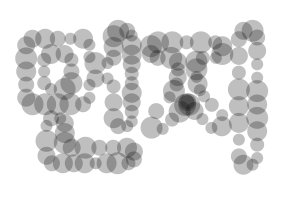

In [8]:
from math import sqrt
import numpy as np

page = document(300, 200, 'pt').addpage()
pen = shape().nostroke().fill(rgba(0, 0, 0, 64))
factor = 144 / f.density

cx = 0
cy = 0

glyph_path = combine_path(f, "먼지").scale(factor).translate(20, 144)

for cmd in glyph_path:
    if type(cmd) in (lineto, curveto, quadto):
        #radius = sqrt(pow(cx - cmd.x, 2) + pow(cy - cmd.y, 2)) * 0.5
        radius = np.random.randint(6,12)
        #radius = 5
        page.place(pen.circle((cx + cmd.x) / 2, (cy + cmd.y) / 2, radius))
    if type(cmd) != type(closepath):
        cx = cmd.x
        cy = cmd.y

show(page)